# Regularización

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as lm
%matplotlib inline

url = 'http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data'
df = pd.read_csv(url, sep='\t', header=0)
df = df.drop('Unnamed: 0', axis=1)
istrain_str = df['train']
istrain = np.asarray([True if s == 'T' else False for s in istrain_str])
df = df.drop('train', axis=1)

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled['lpsa'] = df['lpsa']

X = df_scaled.ix[:,:-1]
N = X.shape[0]
X.insert(X.shape[1], 'intercept', np.ones(N))
y = df_scaled['lpsa']

## a. Ridge Regression

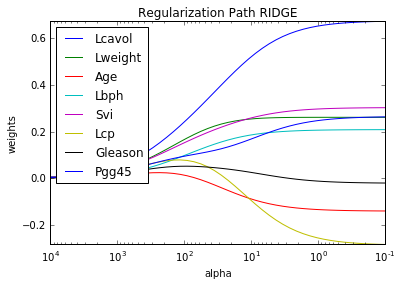

In [2]:
from sklearn.linear_model import Ridge
import matplotlib.pylab as plt

X = X.drop('intercept', axis=1)
Xtrain = X[istrain]
ytrain = y[istrain]
names_regressors = ["Lcavol", "Lweight", "Age", "Lbph", "Svi", "Lcp", "Gleason", "Pgg45"]

alphas_ = np.logspace(4,-1,base=10)
coefs = []
model = Ridge(fit_intercept=True,solver='svd')
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    # print alphas_.shape
    # print y_arr.shape
    plt.plot(alphas_, y_arr, label=label)

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Regularization Path RIDGE')
plt.axis('tight')
plt.legend(loc=2)

## b. Lasso Regression

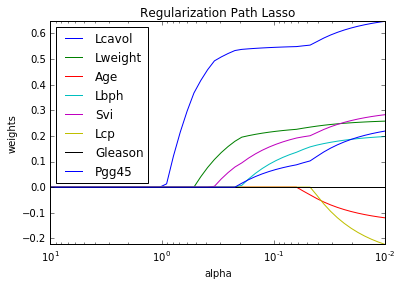

In [3]:
from sklearn.linear_model import Lasso
alphas_ = np.logspace(1, -2, base=10)
model = Lasso(fit_intercept=True)
coefs = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    coefs.append(model.coef_)

ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    # print alphas_.shape
    # print y_arr.shape
    plt.plot(alphas_, y_arr, label=label)

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Regularization Path Lasso')
plt.axis('tight')
plt.legend(loc=2)

## c. Errores de entrenamiento y pruebas (Ridge Regression)

MSE mínimo de test (Ridge):  0.485847414042


(100.0, 0.01)

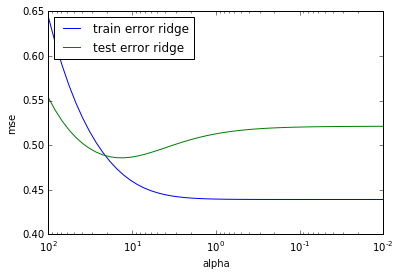

In [4]:
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]
alphas_ = np.logspace(2, -2, base=10)
coefs = []
model = Ridge(fit_intercept=True)
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    yhat_train = model.predict(Xtrain)
    yhat_test = model.predict(Xtest)
    mse_train.append(np.mean(np.power(yhat_train - ytrain, 2)))
    mse_test.append(np.mean(np.power(yhat_test - ytest, 2)))

print "MSE mínimo de test (Ridge): ", min(mse_test)
ax = plt.gca()
ax.plot(alphas_, mse_train, label='train error ridge')
ax.plot(alphas_, mse_test, label='test error ridge')
plt.legend(loc=2)
plt.xlabel('alpha')
plt.ylabel('mse')
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

## d. Errores de entrenamiento y pruebas (Lasso Regression)

MSE mínimo de test (Lasso):  0.452565037028


(1.0, 0.001)

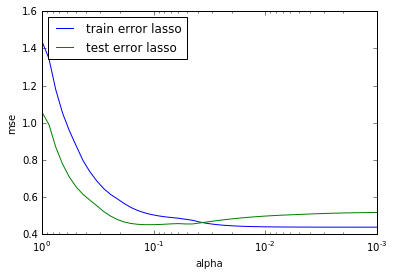

In [5]:
alphas_ = np.logspace(0, -3, base=10)
coefs = []
model = Lasso(fit_intercept=True)
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    yhat_train = model.predict(Xtrain)
    yhat_test = model.predict(Xtest)
    mse_train.append(np.mean(np.power(yhat_train - ytrain, 2)))
    mse_test.append(np.mean(np.power(yhat_test - ytest, 2)))

print "MSE mínimo de test (Lasso): ", min(mse_test)
ax = plt.gca()
ax.plot(alphas_, mse_train, label='train error lasso')
ax.plot(alphas_, mse_test, label='test error lasso')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.legend(loc=2)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

## e. Estimación del valor de regularización con cross-validation

In [6]:
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error

def best_parameter(x, y, method, alphas):
    Xm = x.as_matrix()
    ym = y.as_matrix()

    if method == "lasso":
        model = Lasso(fit_intercept=True)
    elif method == "ridge":
        model = Ridge(fit_intercept=True)

    k_fold = cross_validation.KFold(len(Xm), 10)
    best_cv_mse = float("inf")

    for a in alphas:
        model.set_params(alpha=a)
        mse_list_k10 = [
                    mean_squared_error(model.fit(Xm[train], ym[train]).predict(Xm[val]), ym[val])
                    for train, val in k_fold]
        if np.mean(mse_list_k10) < best_cv_mse:
            best_cv_mse = np.mean(mse_list_k10)
            best_alpha = a
            print method, "BEST PARAMETER=%f, MSE(CV)=%f" % (best_alpha, best_cv_mse)


best_parameter(Xtrain, ytrain, 'ridge', np.logspace(2, -2, base=10))
best_parameter(Xtrain, ytrain, 'lasso', np.logspace(0, -3, base=10))


ridge BEST PARAMETER=100.000000, MSE(CV)=0.999646
ridge BEST PARAMETER=82.864277, MSE(CV)=0.965780
ridge BEST PARAMETER=68.664885, MSE(CV)=0.935286
ridge BEST PARAMETER=56.898660, MSE(CV)=0.908007
ridge BEST PARAMETER=47.148664, MSE(CV)=0.883727
ridge BEST PARAMETER=39.069399, MSE(CV)=0.862205
ridge BEST PARAMETER=32.374575, MSE(CV)=0.843206
ridge BEST PARAMETER=26.826958, MSE(CV)=0.826516
ridge BEST PARAMETER=22.229965, MSE(CV)=0.811949
ridge BEST PARAMETER=18.420700, MSE(CV)=0.799351
ridge BEST PARAMETER=15.264180, MSE(CV)=0.788588
ridge BEST PARAMETER=12.648552, MSE(CV)=0.779537
ridge BEST PARAMETER=10.481131, MSE(CV)=0.772077
ridge BEST PARAMETER=8.685114, MSE(CV)=0.766076
ridge BEST PARAMETER=7.196857, MSE(CV)=0.761390
ridge BEST PARAMETER=5.963623, MSE(CV)=0.757863
ridge BEST PARAMETER=4.941713, MSE(CV)=0.755328
ridge BEST PARAMETER=4.094915, MSE(CV)=0.753618
ridge BEST PARAMETER=3.393222, MSE(CV)=0.752571
ridge BEST PARAMETER=2.811769, MSE(CV)=0.752036
ridge BEST PARAMETER=2.329